# LSTM Baseline

In [1]:
# Import necessary modules
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, TimeDistributed

In [2]:
# Change this to the path of the data directory
path = "./clin-summ/data"

seed = 42

In [3]:
import os

assert os.path.exists(path), 'Dataset not found ({})'.format(data_path)

def load_data(path):
    df = pd.read_json(os.path.join(path, "train.jsonl"), lines=True)
    train_x, train_y = df["inputs"].to_numpy(), df["target"].to_numpy()
    df = pd.read_json(os.path.join(path, "test.jsonl"), lines=True)
    test_x, test_y = df["inputs"].to_numpy(), df["target"].to_numpy()
    
    return (train_x, train_y, test_x, test_y)

opi = load_data(os.path.join(path, 'opi'))
d2n = load_data(os.path.join(path, 'd2n'))
chq = load_data(os.path.join(path, 'chq'))

all_xy = np.concatenate((opi, d2n, chq))
train_x = all_xy[0]
train_y = all_xy[1]
test_x = all_xy[2]
test_y = all_xy[3]
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(2735,) (2735,) (343,) (343,)


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [4]:
# Add start and end tokens to summaries
train_y = ['sostok ' + y + ' eostok' for y in train_y]
test_y = ['sostok ' + y + ' eostok' for y in test_y]

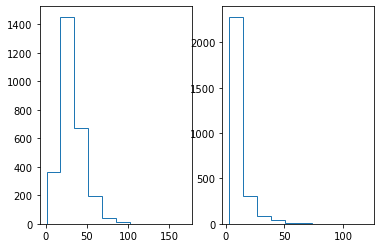

In [5]:
import matplotlib.pyplot as plt

text_lengths = [len(text.split()) for text in train_x]
summary_lengths = [len(summary.split()) for summary in train_y]

# Show the distribution of text/summary lengths

fig, (ax1, ax2) = plt.subplots(1, 2)
counts_x, bins_x = np.histogram(text_lengths)
ax1.stairs(counts_x, bins_x)
counts_y, bins_y = np.histogram(summary_lengths)
ax2.stairs(counts_y, bins_y)

In [6]:
print('Percent of texts with < 80 words: ', len([x for x in train_x if len(x.split()) <= 80]) / len(train_x))
print('Percent of summaries with < 50 words: ', len([y for y in train_y if len(y.split()) <= 50]) / len(train_y))

Percent of texts with < 80 words:  0.9904936014625229
Percent of summaries with < 50 words:  0.9912248628884827


In [7]:
max_text_len = 80
max_summary_len = 50

In [8]:
new_train_x = []
new_train_y = []

for i in range(len(train_x)):
    if len(train_x[i].split()) <= 80 and len(train_y[i].split()) <= 50:
        new_train_x.append(train_x[i])
        new_train_y.append(train_y[i])
    
train_x = np.array(new_train_x)
train_y = np.array(new_train_y)

In [9]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=seed)

In [10]:
from keras.layers import TextVectorization

# Tokenize text and summaries, and pad to maximum length.

max_tokens = 5000
x_tokenizer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int')
x_tokenizer.adapt(train_x)

train_x_seq = x_tokenizer(train_x)
val_x_seq = x_tokenizer(val_x)
test_x_seq = x_tokenizer(test_x)

y_tokenizer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int')
y_tokenizer.adapt(train_y)

train_y_seq = y_tokenizer(train_y)
val_y_seq = y_tokenizer(val_y)
test_y_seq = y_tokenizer(test_y)

# Pad text/summaries to max length by adding 0s at the end.
encoder_input_tr = pad_sequences(train_x_seq, maxlen=max_text_len, padding="post")
encoder_input_val = pad_sequences(val_x_seq, maxlen=max_text_len, padding="post")
encoder_input_test = pad_sequences(test_x_seq, maxlen=max_text_len, padding="post")

decoder_input_tr = pad_sequences(train_y_seq, maxlen=max_summary_len, padding="post")
decoder_input_val = pad_sequences(val_y_seq, maxlen=max_summary_len, padding="post")
decoder_input_test = pad_sequences(test_y_seq, maxlen=max_summary_len, padding="post")

# Move sequence back one step for teacher forcing.
decoder_target_tr = np.roll(decoder_input_tr, -1, axis=1)
decoder_target_tr[:, -1] = 0 
decoder_target_val = np.roll(decoder_input_val, -1, axis=1)
decoder_target_val[:, -1] = 0 
decoder_target_test = np.roll(decoder_input_test, -1, axis=1)
decoder_target_test[:, -1] = 0 

x_voc = len(x_tokenizer.get_vocabulary()) + 1
y_voc = len(y_tokenizer.get_vocabulary()) + 1

2024-04-19 16:15:48.981214: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-19 16:15:48.981241: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-19 16:15:48.981261: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c0709a-s30.ufhpc): /proc/driver/nvidia/version does not exist
2024-04-19 16:15:48.982392: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
print(encoder_input_tr.shape)

(2151, 80)


In [12]:
# Reference: https://github.com/karant-dev/Text-summarization-with-Seq2Seq
latent_dim = 300
embedding_dim = 200

# Encoder Input
encoder_inputs = Input(shape=(max_text_len,), name='enc_input')

# Embedding layer
enc_emb =  Embedding(x_voc, max_text_len, trainable=True, name='enc_embedding')(encoder_inputs)

# Encoder LSTMs
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.5, recurrent_dropout=0.5, name='enc_lstm1')
encoder_outputs1, state_h1, state_c1= encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.5, recurrent_dropout=0.5, name='enc_lstm2')
encoder_outputs2, state_h2, state_c2= encoder_lstm2(encoder_outputs1)

encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.5, recurrent_dropout=0.5, name='enc_lstm3')
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_outputs2)

decoder_inputs = Input(shape=(None,), name='dec_input')

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True, name='dec_embedding')
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.5, recurrent_dropout=0.25, name='dec_lstm')
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

#dense layer - softmax
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'), name='dec_output')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='lstm_baseline')

model.summary()

Model: "lstm_baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_input (InputLayer)         [(None, 80)]         0           []                               
                                                                                                  
 enc_embedding (Embedding)      (None, 80, 80)       113920      ['enc_input[0][0]']              
                                                                                                  
 enc_lstm1 (LSTM)               [(None, 80, 300),    457200      ['enc_embedding[0][0]']          
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                      

In [13]:
lstm_model = 'lstm_model.keras'
from keras.callbacks import EarlyStopping


if os.path.exists(lstm_model):
    model = keras.models.load_model(lstm_model)

else:
    model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    early_stop_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    batch_size = 40
    epochs = 20

    model.fit([encoder_input_tr, decoder_input_tr],
              decoder_target_tr,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=([encoder_input_val, decoder_input_val], decoder_target_val),
              callbacks=[early_stop_cb]
             )

    model.save("lstm_model.keras")

In [14]:
reverse_encode_seq = dict((index, value) for (index, value) in enumerate(x_tokenizer.get_vocabulary()))
reverse_decode_seq = dict((index, value) for (index, value) in enumerate(y_tokenizer.get_vocabulary()))

In [15]:
# Reference: https://keras.io/examples/nlp/lstm_seq2seq/
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [16]:
# Rebuild the model for inference
# Reference: https://keras.io/examples/nlp/lstm_seq2seq/
for layer in model.layers:
    print(layer.name)

model = keras.models.load_model("lstm_model.keras")
encoder_inputs = model.input[0]
encoder_outputs, state_h_enc, state_c_enc = model.layers[6].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]
decoder_emb = model.layers[5](decoder_inputs)
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[7]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_emb, initial_state=decoder_states_inputs)

decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[8]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

def decode_sequence(input_sequence, temp=1.0):
    states_value = encoder_model.predict(input_sequence, verbose=0)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = y_tokenizer('sostok')
    
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )

        # Sample a token
        sampled_token_index = sample(output_tokens[0, -1, :], temp)
        sampled_vocab = reverse_decode_seq[sampled_token_index]

        # Exit condition: either hit max length
        # or find stop character.
        if(sampled_vocab != 'eostok' and len(decoded_sentence) < 200):
            decoded_sentence += ' ' + sampled_vocab
        else:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
    return decoded_sentence

enc_input
enc_embedding
enc_lstm1
dec_input
enc_lstm2
dec_embedding
enc_lstm3
dec_lstm
dec_output


In [21]:
# Generate summaries for the test set

targets_list = [' '.join(y.split()[1:-1]) for y in test_y]
summaries = []

for seq_index in range(0, len(encoder_input_test)):
    input_seq = encoder_input_test[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, temp=0.5)
    summaries.append(decoded_sentence)

In [20]:
from bert_score import BERTScorer

scorer = BERTScorer(model_type='bert-base-uncased')
P, R, F1 = scorer.score(summaries, targets_list)
print(f"BERTScore Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

BERTScore Precision: 0.6994, Recall: 0.6570, F1: 0.6694


In [25]:
from nltk.translate.bleu_score import sentence_bleu

all_bleu_scores = []
for references, candidates in zip(targets_list, summaries):
    bleu_score = sentence_bleu([references.split()], candidates.split())
    all_bleu_scores.append(bleu_score)

average_bleu_score = sum(all_bleu_scores) / len(all_bleu_scores)
print(f'Average BLEU Score: {average_bleu_score:.4f}')

Average BLEU Score: 0.0005


In [27]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)

all_rouge_scores = []
for references, candidates in zip(targets_list, summaries):
    scores = scorer.score(references, candidates)
    all_rouge_scores.append(scores["rouge1"])

total_recall = sum(score.recall for score in all_rouge_scores) / len(all_rouge_scores)
total_precision = sum(score.precision for score in all_rouge_scores) / len(all_rouge_scores)
total_fmeasure = sum(score.fmeasure for score in all_rouge_scores) / len(all_rouge_scores)

print(f"Average Recall: {total_recall}")
print(f"Average Precision: {total_precision}")
print(f"Average F4: {total_fmeasure}")

Average Recall: 0.44196808016151623
Average Precision: 0.526726221624181
Average F4: 0.4578809292195143
